In [1]:
from utils.alloys import alloy_to_1d_tensor
from utils.constants import alloy_max_len, n_elements
from utils.ml import *
from utils.dataframes import dfs_tabs

2023-07-12 20:54:26.019151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 20:54:26.564650: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-12 20:54:27.880008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-07-12 20:54:27.880160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerro

This file is to train and test models for d_max prediction and build the best possible model for the problem.

## References:

1. https://discuss.huggingface.co/t/what-does-increasing-number-of-heads-do-in-the-multi-head-attention/1847/2

In [2]:
df_train = pd.read_excel("dataset.xlsx", sheet_name="train")
df_test = pd.read_excel("dataset.xlsx", sheet_name="test")
display(df_train)
display(df_test)

,bmg_alloy,delta_h_mix,delta_s_mix,delta_d,delta_e,actual_d_max
0,Al92.0Ni2.0Nd6.0,10.61,0.32,0.20,-0.17,0.00
1,Be20.0Mg24.0Ti10.0Ni8.0Cu8.0Y4.0Zr26.0,13.89,1.78,0.17,-0.12,5.00
2,Al20.0Mn3.0Ni22.0Gd55.0,11.82,1.09,0.26,-0.18,2.00
3,Mg15.4Ca30.8Ag53.8,10.05,0.98,0.25,-0.28,0.80
4,Ni60.0Zr20.0Nb20.0,19.88,0.95,0.17,-0.13,0.50
...,...,...,...,...,...,...
1054,Mg65.0Ni7.5Cu7.5Zn5.0Y2.5Ag5.0Gd7.5,9.89,1.25,0.18,-0.16,13.00
1055,Mg65.0Ni7.5Cu7.5Zn5.0Y7.5Ag5.0Gd2.5,9.96,1.25,0.17,-0.16,9.50
1056,Mg80.0Ni10.0Nd10.0,9.39,0.64,0.25,-0.09,0.60
1057,Mg31.8Ca22.7Cu45.5,10.66,1.06,0.34,-0.25,1.25


,bmg_alloy,delta_h_mix,delta_s_mix,delta_d,delta_e,actual_d_max,predicted_d_max
0,P17.0Co14.0Ni69.0,14.24,0.83,0.12,0.04,0.00,0.02
1,C14.0Fe66.0W20.0,30.81,0.87,0.14,-0.13,0.00,0.00
2,Mg55.0Cu15.0La30.0,8.64,0.97,0.31,-0.13,0.00,1.77
3,Al87.5Ca2.5Ni10.0,11.30,0.44,0.21,-0.24,0.00,-0.01
4,B36.0C8.0Co56.0,35.47,0.89,0.11,-0.14,0.00,-0.03
...,...,...,...,...,...,...,...
257,Al20.0Ni25.0Gd55.0,11.94,1.00,0.27,-0.19,2.00,1.36
258,Mg65.0Ni20.0La15.0,10.04,0.89,0.29,-0.14,0.50,0.44
259,B8.0Fe89.0Ni3.0,16.80,0.41,0.16,-0.02,0.00,0.02
260,Al14.0Cu18.0Ag6.0La62.0,8.44,1.05,0.36,-0.23,5.00,5.77


## 1. Encode the bmg_alloys using an RNNs


Since we want to enhance the pre-existing model that predicts the d_max value, we utilize the column with the "bmg_alloy" (the string representation of the alloy), encoding these using an RNN to predict the d_max.

We want to then how well this model does on it's own, but since we know that with other descriptors the model shall become much better, therefore in the next step we shall create another model with the output of this model as an input to it.

In [3]:
# constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# max_factor = max(max(df_train["actual_d_max"]), max(df_test["actual_d_max"]))
# ideally a max factor is from the training dataset
max_factor = max(df_train["actual_d_max"])
print(max_factor)

30.0


In [4]:
# creating the input and output data for the model
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(df_train.shape[0]):
    X_train.append(alloy_to_1d_tensor(df_train.loc[i, "bmg_alloy"]))
    y_train.append(df_train.loc[i, "actual_d_max"] / max_factor)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

print(X_train.shape, X_train.dtype, y_train.shape, min(y_train).item(), max(y_train).item())

torch.Size([1059, 20]) torch.float32 torch.Size([1059]) 0.0 1.0


In [5]:
for i in range(df_test.shape[0]):
    X_test.append(alloy_to_1d_tensor(df_test.loc[i, "bmg_alloy"]))
    y_test.append(df_test.loc[i, "actual_d_max"] / max_factor)
    
# max_factor we selected is fine
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_test.shape, min(y_test).item(), max(y_test).item())

torch.Size([262, 20]) 0.0 0.6666666865348816


In [6]:
import torch
from torch import nn

class SequenceToSigmoid(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [7]:
# Bidirectional LSTM
# Define hyperparameters
input_size = 20
hidden_size = 128
learning_rate = 0.001
num_epochs = 2000
batch_size = 32
num_layers = 3

# Create an instance of the model
model = SequenceToSigmoid(input_size, hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

# Create a PyTorch DataLoader for batching the data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set the device to use (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print_every = 100
# TODO: print the average loss
# EDIT: we are printing epoch loss of batch

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Iterate over the batches of data
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        # print("output", outputs.squeeze(), "\nlabel", labels)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    
    # Print the loss for this epoch
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/2000, Loss: 0.3157
Epoch 101/2000, Loss: 0.1912
Epoch 201/2000, Loss: 0.1878
Epoch 301/2000, Loss: 0.1910
Epoch 401/2000, Loss: 0.1862
Epoch 501/2000, Loss: 0.1820
Epoch 601/2000, Loss: 0.1908
Epoch 701/2000, Loss: 0.1860
Epoch 801/2000, Loss: 0.1892
Epoch 901/2000, Loss: 0.1864
Epoch 1001/2000, Loss: 0.1880
Epoch 1101/2000, Loss: 0.1818
Epoch 1201/2000, Loss: 0.1893
Epoch 1301/2000, Loss: 0.1885
Epoch 1401/2000, Loss: 0.1816
Epoch 1501/2000, Loss: 0.1818
Epoch 1601/2000, Loss: 0.1850
Epoch 1701/2000, Loss: 0.1821
Epoch 1801/2000, Loss: 0.1857
Epoch 1901/2000, Loss: 0.1841


In [8]:
# Assuming you have a separate validation dataset X_val and y_val

# Set the model in evaluation mode
model.eval()

# Convert the validation data to PyTorch tensors
X_val_tensor = torch.Tensor(X_test)
y_val_tensor = torch.Tensor(y_test)

# Create a PyTorch DataLoader for batching the validation data
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

predicted_labels = []
true_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Append the predicted and true labels to the lists
        predicted_labels.extend(outputs.squeeze())
        true_labels.extend(labels)

# Calculate the R2 score
# for i in range(len(true_labels)):
#     print(true_labels[i], predicted_labels[i])

In [9]:
r2 = r2_score(np.array(true_labels)*max_factor, np.array(predicted_labels)*max_factor)
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.6558


<AxesSubplot:>

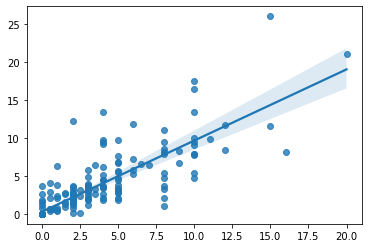

In [10]:
sns.regplot(x=np.array(true_labels)*max_factor, y=np.array(predicted_labels)*max_factor)

In [11]:
torch.save(model.state_dict(), "rnn_trainset_trained.pt")

## 2. Predict d_max and create a new dataset (dataset_rnn) to train another model on

In this step we use the RNN models predictions to add a new feature to our current dataset and see if the predictions can be improved.

In [12]:
all_rnn_train_output = []
for i in range(df_train.shape[0]):
    alloy_tensor = alloy_to_1d_tensor(df_train.loc[i, "bmg_alloy"])
    output = model(torch.atleast_2d(alloy_tensor))
    all_rnn_train_output.append(output.squeeze().item() * max_factor)

all_rnn_test_output = []
for i in range(df_test.shape[0]):
    alloy_tensor = alloy_to_1d_tensor(df_test.loc[i, "bmg_alloy"])
    output = model(torch.atleast_2d(alloy_tensor))
    all_rnn_test_output.append(output.squeeze().item() * max_factor)
    
new_train = df_train
new_test = df_test


new_train["rnn_encoding"] = all_rnn_train_output
new_test["rnn_encoding"] = all_rnn_test_output


    
dfs = [new_train, new_test]
sheets = ["train", "test"]
dfs_tabs(dfs, sheets, 'dataset_rnn.xlsx')

In [13]:
df_train = pd.read_excel("dataset_rnn.xlsx", sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", sheet_name="test")
display(df_train)
display(df_test)

,bmg_alloy,delta_h_mix,delta_s_mix,delta_d,delta_e,actual_d_max,rnn_encoding
0,Al92.0Ni2.0Nd6.0,10.61,0.32,0.20,-0.17,0.00,0.00
1,Be20.0Mg24.0Ti10.0Ni8.0Cu8.0Y4.0Zr26.0,13.89,1.78,0.17,-0.12,5.00,5.26
2,Al20.0Mn3.0Ni22.0Gd55.0,11.82,1.09,0.26,-0.18,2.00,2.25
3,Mg15.4Ca30.8Ag53.8,10.05,0.98,0.25,-0.28,0.80,0.82
4,Ni60.0Zr20.0Nb20.0,19.88,0.95,0.17,-0.13,0.50,0.57
...,...,...,...,...,...,...,...
1054,Mg65.0Ni7.5Cu7.5Zn5.0Y2.5Ag5.0Gd7.5,9.89,1.25,0.18,-0.16,13.00,13.45
1055,Mg65.0Ni7.5Cu7.5Zn5.0Y7.5Ag5.0Gd2.5,9.96,1.25,0.17,-0.16,9.50,9.65
1056,Mg80.0Ni10.0Nd10.0,9.39,0.64,0.25,-0.09,0.60,1.06
1057,Mg31.8Ca22.7Cu45.5,10.66,1.06,0.34,-0.25,1.25,1.72


,bmg_alloy,delta_h_mix,delta_s_mix,delta_d,delta_e,actual_d_max,predicted_d_max,rnn_encoding
0,P17.0Co14.0Ni69.0,14.24,0.83,0.12,0.04,0.00,0.02,0.00
1,C14.0Fe66.0W20.0,30.81,0.87,0.14,-0.13,0.00,0.00,0.00
2,Mg55.0Cu15.0La30.0,8.64,0.97,0.31,-0.13,0.00,1.77,0.00
3,Al87.5Ca2.5Ni10.0,11.30,0.44,0.21,-0.24,0.00,-0.01,0.00
4,B36.0C8.0Co56.0,35.47,0.89,0.11,-0.14,0.00,-0.03,0.00
...,...,...,...,...,...,...,...,...
257,Al20.0Ni25.0Gd55.0,11.94,1.00,0.27,-0.19,2.00,1.36,0.87
258,Mg65.0Ni20.0La15.0,10.04,0.89,0.29,-0.14,0.50,0.44,0.38
259,B8.0Fe89.0Ni3.0,16.80,0.41,0.16,-0.02,0.00,0.02,0.00
260,Al14.0Cu18.0Ag6.0La62.0,8.44,1.05,0.36,-0.23,5.00,5.77,5.11


In [14]:
df_train = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="test")
df_test = df_test.drop(["predicted_d_max"], axis=1)
X_train, y_train = df_train.loc[:, df_train.columns != "actual_d_max"], pd.DataFrame(df_train["actual_d_max"])
X_test, y_test = df_test.loc[:, df_test.columns != "actual_d_max"], pd.DataFrame(df_test["actual_d_max"])

R2 = []
ADJR2 = []
RMSE = []
names = []
TIME = []

for name, model in tqdm(REGRESSORS):
    start = time.time()
    pipe = Pipeline(steps=[
                        ("classifier", model()),
                    ]
                )
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        r_squared = r2_score(y_test, y_pred)
        print(name, r_squared)
        adj_rsquared = adjusted_rsquared(
            r_squared, X_test.shape[0], X_test.shape[1]
        )
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        names.append(name)
        R2.append(r_squared)
        ADJR2.append(adj_rsquared)
        RMSE.append(rmse)
        TIME.append(time.time() - start)
    except Exception as exception:
        print(name + " model failed to execute")
        print(exception)
    scores = {
                "Model": names,
                "Adjusted R-Squared": ADJR2,
                "R-Squared": R2,
                "RMSE": RMSE,
                "Time Taken": TIME,
            }
    scores = pd.DataFrame(scores)
    scores = scores.sort_values(by = "Adjusted R-Squared", ascending = False).set_index("Model")

 21%|██████████████████                                                                  | 9/42 [00:00<00:00, 36.70it/s]

AdaBoostRegressor 0.6217553380839744
BaggingRegressor 0.6582845212967718
BayesianRidge 0.6600163427909284
DecisionTreeRegressor 0.5753546729738519
DummyRegressor -0.0002730252917726439
ElasticNet 0.693124863065862
ElasticNetCV 0.6660594931801749
ExtraTreeRegressor 0.6393667080418346
ExtraTreesRegressor 0.6705046611389288
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor -1.4998090548682934
GradientBoostingRegressor 0.6568804399250857


 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 23.80it/s]

HistGradientBoostingRegressor 0.6478005324521198
HuberRegressor 0.672204636954626
KNeighborsRegressor 0.6827458622205346
KernelRidge 0.6603085955507301
Lars 0.6598347728084264
LarsCV 0.6603520940998475
Lasso 0.6937147148962258
LassoCV 0.6655109538037587
LassoLars 0.6937147148962259
LassoLarsCV 0.6603520940998475
LassoLarsIC 0.6601420056854344
LinearRegression 0.6598347728084264
LinearSVR 0.6651038570579513


 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:01<00:00, 18.38it/s]

MLPRegressor 0.6585456634552194
NuSVR 0.6831164110196182
OrthogonalMatchingPursuit 0.6649261294953523
OrthogonalMatchingPursuitCV 0.6598728874148277
PassiveAggressiveRegressor 0.19320695421638945
PoissonRegressor 0.23803741611621354
RANSACRegressor -0.4545030445276721


 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:01<00:00, 16.89it/s]

RandomForestRegressor 0.6653605788677869
Ridge 0.6599507616783564
RidgeCV 0.660943333202018
SGDRegressor 0.6536911358221315
SVR 0.6819537729271486
TransformedTargetRegressor 0.6598347728084264
TweedieRegressor 0.6928807858234325


 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:02<00:00, 18.99it/s]

XGBRegressor 0.6713525758220218
LGBMRegressor 0.6539086396446312
Learning rate set to 0.041316
0:	learn: 3.9747053	total: 51.6ms	remaining: 51.6s
1:	learn: 3.8395407	total: 52.4ms	remaining: 26.2s
2:	learn: 3.7122169	total: 53.1ms	remaining: 17.6s
3:	learn: 3.5984786	total: 53.8ms	remaining: 13.4s
4:	learn: 3.4949944	total: 54.4ms	remaining: 10.8s
5:	learn: 3.3805762	total: 55.1ms	remaining: 9.13s
6:	learn: 3.2776544	total: 55.7ms	remaining: 7.9s
7:	learn: 3.1719898	total: 56.3ms	remaining: 6.98s
8:	learn: 3.0661805	total: 57ms	remaining: 6.27s
9:	learn: 2.9668605	total: 57.7ms	remaining: 5.71s
10:	learn: 2.8699015	total: 58.5ms	remaining: 5.26s
11:	learn: 2.7905035	total: 59.2ms	remaining: 4.88s
12:	learn: 2.7042980	total: 59.8ms	remaining: 4.54s
13:	learn: 2.6263062	total: 61ms	remaining: 4.3s
14:	learn: 2.5470358	total: 61.8ms	remaining: 4.06s
15:	learn: 2.4713356	total: 62.4ms	remaining: 3.84s
16:	learn: 2.3905517	total: 63.2ms	remaining: 3.65s
17:	learn: 2.3252132	total: 63.9ms	re

323:	learn: 0.3881991	total: 306ms	remaining: 638ms
324:	learn: 0.3874136	total: 307ms	remaining: 637ms
325:	learn: 0.3870278	total: 308ms	remaining: 636ms
326:	learn: 0.3863758	total: 309ms	remaining: 635ms
327:	learn: 0.3861825	total: 310ms	remaining: 634ms
328:	learn: 0.3855775	total: 311ms	remaining: 633ms
329:	learn: 0.3848187	total: 311ms	remaining: 632ms
330:	learn: 0.3844528	total: 312ms	remaining: 631ms
331:	learn: 0.3839262	total: 313ms	remaining: 630ms
332:	learn: 0.3832017	total: 314ms	remaining: 629ms
333:	learn: 0.3826428	total: 314ms	remaining: 627ms
334:	learn: 0.3817764	total: 315ms	remaining: 626ms
335:	learn: 0.3811594	total: 316ms	remaining: 624ms
336:	learn: 0.3806296	total: 317ms	remaining: 623ms
337:	learn: 0.3801323	total: 318ms	remaining: 622ms
338:	learn: 0.3797826	total: 319ms	remaining: 621ms
339:	learn: 0.3791662	total: 319ms	remaining: 620ms
340:	learn: 0.3785806	total: 320ms	remaining: 619ms
341:	learn: 0.3783510	total: 321ms	remaining: 618ms
342:	learn: 

556:	learn: 0.2965936	total: 495ms	remaining: 394ms
557:	learn: 0.2963400	total: 496ms	remaining: 393ms
558:	learn: 0.2960882	total: 497ms	remaining: 392ms
559:	learn: 0.2956921	total: 498ms	remaining: 391ms
560:	learn: 0.2950162	total: 499ms	remaining: 390ms
561:	learn: 0.2943430	total: 500ms	remaining: 389ms
562:	learn: 0.2939636	total: 500ms	remaining: 388ms
563:	learn: 0.2934359	total: 501ms	remaining: 388ms
564:	learn: 0.2931307	total: 502ms	remaining: 387ms
565:	learn: 0.2925824	total: 503ms	remaining: 386ms
566:	learn: 0.2919392	total: 504ms	remaining: 385ms
567:	learn: 0.2917638	total: 504ms	remaining: 384ms
568:	learn: 0.2914803	total: 506ms	remaining: 383ms
569:	learn: 0.2912341	total: 507ms	remaining: 382ms
570:	learn: 0.2908256	total: 507ms	remaining: 381ms
571:	learn: 0.2902969	total: 508ms	remaining: 380ms
572:	learn: 0.2898755	total: 509ms	remaining: 379ms
573:	learn: 0.2894413	total: 509ms	remaining: 378ms
574:	learn: 0.2889756	total: 510ms	remaining: 377ms
575:	learn: 

794:	learn: 0.2313768	total: 684ms	remaining: 176ms
795:	learn: 0.2310943	total: 685ms	remaining: 176ms
796:	learn: 0.2310229	total: 686ms	remaining: 175ms
797:	learn: 0.2307512	total: 687ms	remaining: 174ms
798:	learn: 0.2306306	total: 688ms	remaining: 173ms
799:	learn: 0.2303840	total: 688ms	remaining: 172ms
800:	learn: 0.2303092	total: 689ms	remaining: 171ms
801:	learn: 0.2301504	total: 690ms	remaining: 170ms
802:	learn: 0.2300916	total: 691ms	remaining: 169ms
803:	learn: 0.2298356	total: 691ms	remaining: 169ms
804:	learn: 0.2297721	total: 692ms	remaining: 168ms
805:	learn: 0.2295492	total: 693ms	remaining: 167ms
806:	learn: 0.2292919	total: 694ms	remaining: 166ms
807:	learn: 0.2292120	total: 695ms	remaining: 165ms
808:	learn: 0.2291510	total: 696ms	remaining: 164ms
809:	learn: 0.2289930	total: 696ms	remaining: 163ms
810:	learn: 0.2288417	total: 697ms	remaining: 162ms
811:	learn: 0.2287631	total: 698ms	remaining: 162ms
812:	learn: 0.2286181	total: 698ms	remaining: 161ms
813:	learn: 

100%|███████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 13.51it/s]

CatBoostRegressor 0.6712120809879232


In [15]:
display(scores)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoLars,0.69,0.69,1.93,0.01
Lasso,0.69,0.69,1.93,0.01
ElasticNet,0.69,0.69,1.93,0.00
TweedieRegressor,0.69,0.69,1.93,0.00
NuSVR,0.68,0.68,1.96,0.09
KNeighborsRegressor,0.68,0.68,1.97,0.01
SVR,0.68,0.68,1.97,0.02
HuberRegressor,0.67,0.67,2.00,0.02
XGBRegressor,0.66,0.67,2.00,0.25


In [16]:
df_train = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="test")
df_test = df_test.drop(["predicted_d_max"], axis=1)
X_train, y_train = df_train.loc[:, df_train.columns != "actual_d_max"], pd.DataFrame(df_train["actual_d_max"])
X_test, y_test = df_test.loc[:, df_test.columns != "actual_d_max"], pd.DataFrame(df_test["actual_d_max"])

R2 = []
ADJR2 = []
RMSE = []
names = []
TIME = []

for transformer_method_name, transformer_method in tqdm(TRANSFOMER_METHODS):
    for name, model in tqdm(REGRESSORS):
        start = time.time()
        X_transformer = transformer_method()
        y_transformer = transformer_method()
        transformed_X_train = pd.DataFrame(X_transformer.fit_transform(X_train), columns = X_train.columns)
        transformed_X_test = pd.DataFrame(X_transformer.transform(X_test), columns = X_test.columns)

        transformed_y_train = pd.DataFrame(y_transformer.fit_transform(y_train), columns = y_train.columns)
        transformed_y_test = pd.DataFrame(y_transformer.transform(y_test), columns = y_test.columns)
        pipe = Pipeline(steps=[
                            ("classifier", model()),
                        ]
                    )
        try:
            pipe.fit(transformed_X_train, transformed_y_train)
            transformed_y_pred = pipe.predict(transformed_X_test)
            r_squared = r2_score(transformed_y_test, transformed_y_pred)
            adj_rsquared = adjusted_rsquared(
                r_squared, transformed_X_test.shape[0], transformed_X_test.shape[1]
            )
            rmse = np.sqrt(mean_squared_error(transformed_y_test, transformed_y_pred))
            names.append(name + " (" + transformer_method_name + ")")
            print(name + " (" + transformer_method_name + ")", r_squared)
            R2.append(r_squared)
            ADJR2.append(adj_rsquared)
            RMSE.append(rmse)
            TIME.append(time.time() - start)
        except Exception as exception:
            print(name + " (" + transformer_method_name + ")" + " model failed to execute")
            print(exception)
        scores = {
                    "Model": names,
                    "Adjusted R-Squared": ADJR2,
                    "R-Squared": R2,
                    "RMSE": RMSE,
                    "Time Taken": TIME,
                }
        scores = pd.DataFrame(scores)
        scores = scores.sort_values(by = "Adjusted R-Squared", ascending = False).set_index("Model")

  5%|████                                                                                | 2/42 [00:00<00:02, 18.54it/s]

AdaBoostRegressor (StandardScaler) 0.6331871950940329
BaggingRegressor (StandardScaler) 0.6482246224598178
BayesianRidge (StandardScaler) 0.6599173347107248
DecisionTreeRegressor (StandardScaler) 0.5756869953755468
DummyRegressor (StandardScaler) -0.0002730252917721998
ElasticNet (StandardScaler) 0.4861410533730711
ElasticNetCV (StandardScaler) 0.6619666765916826
ExtraTreeRegressor (StandardScaler) 0.6295012786311418



 21%|██████████████████                                                                  | 9/42 [00:00<00:01, 32.06it/s]

ExtraTreesRegressor (StandardScaler) 0.6756700305002132
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (StandardScaler) -86.66870623397848



 29%|███████████████████████▋                                                           | 12/42 [00:00<00:01, 18.83it/s]

GradientBoostingRegressor (StandardScaler) 0.6552763703975568
HistGradientBoostingRegressor (StandardScaler) 0.6478005324135505



 40%|█████████████████████████████████▌                                                 | 17/42 [00:00<00:01, 17.08it/s]

HuberRegressor (StandardScaler) 0.6722048771802074
KNeighborsRegressor (StandardScaler) 0.6870449164837739
KernelRidge (StandardScaler) 0.6605599876722562
Lars (StandardScaler) 0.6598347728084265
LarsCV (StandardScaler) 0.6611674267397417
Lasso (StandardScaler) -0.0002730252917721998



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:01<00:00, 21.82it/s]

LassoCV (StandardScaler) 0.6611635166751091
LassoLars (StandardScaler) -0.0002730252917721998
LassoLarsCV (StandardScaler) 0.6611674267397417
LassoLarsIC (StandardScaler) 0.661712503804575
LinearRegression (StandardScaler) 0.6598347728084261
LinearSVR (StandardScaler) 0.673019682789623



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:01<00:00, 16.48it/s]

MLPRegressor (StandardScaler) 0.6592730120252033
NuSVR (StandardScaler) 0.676702030864439
OrthogonalMatchingPursuit (StandardScaler) 0.6649261294953525
OrthogonalMatchingPursuitCV (StandardScaler) 0.6598728874148281
PassiveAggressiveRegressor (StandardScaler) 0.6725388404452961
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (StandardScaler) -0.4545030445276719



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:02<00:00, 22.15it/s]

RandomForestRegressor (StandardScaler) 0.6520701345335902
Ridge (StandardScaler) 0.6605599876722563
RidgeCV (StandardScaler) 0.6599075428162271
SGDRegressor (StandardScaler) 0.6614005556740103
SVR (StandardScaler) 0.6799717935097163
TransformedTargetRegressor (StandardScaler) 0.6598347728084261
TweedieRegressor (StandardScaler) 0.6855937399386786
XGBRegressor (StandardScaler) 0.6607358752902166
LGBMRegressor (StandardScaler) 0.6590288259965367
Learning rate set to 0.041316
0:	learn: 0.9666315	total: 1.8ms	remaining: 1.8s
1:	learn: 0.9359094	total: 2.58ms	remaining: 1.29s
2:	learn: 0.9046226	total: 3.28ms	remaining: 1.09s
3:	learn: 0.8771830	total: 3.98ms	remaining: 992ms
4:	learn: 0.8506771	total: 4.88ms	remaining: 972ms
5:	learn: 0.8226820	total: 5.74ms	remaining: 950ms
6:	learn: 0.7954379	total: 6.79ms	remaining: 964ms
7:	learn: 0.7700964	total: 7.61ms	remaining: 944ms
8:	learn: 0.7438789	total: 8.4ms	remaining: 925ms
9:	learn: 0.7202622	total: 9.14ms	remaining: 905ms
10:	learn: 0.69

224:	learn: 0.1078689	total: 205ms	remaining: 704ms
225:	learn: 0.1077740	total: 205ms	remaining: 704ms
226:	learn: 0.1075620	total: 206ms	remaining: 702ms
227:	learn: 0.1073078	total: 207ms	remaining: 702ms
228:	learn: 0.1071000	total: 209ms	remaining: 702ms
229:	learn: 0.1068446	total: 210ms	remaining: 701ms
230:	learn: 0.1066407	total: 210ms	remaining: 700ms
231:	learn: 0.1064941	total: 211ms	remaining: 699ms
232:	learn: 0.1064061	total: 212ms	remaining: 698ms
233:	learn: 0.1062657	total: 213ms	remaining: 696ms
234:	learn: 0.1061332	total: 214ms	remaining: 695ms
235:	learn: 0.1060351	total: 215ms	remaining: 695ms
236:	learn: 0.1058526	total: 215ms	remaining: 694ms
237:	learn: 0.1056898	total: 217ms	remaining: 693ms
238:	learn: 0.1055026	total: 217ms	remaining: 692ms
239:	learn: 0.1053251	total: 218ms	remaining: 690ms
240:	learn: 0.1052428	total: 219ms	remaining: 689ms
241:	learn: 0.1050605	total: 220ms	remaining: 688ms
242:	learn: 0.1048812	total: 220ms	remaining: 686ms
243:	learn: 

463:	learn: 0.0763621	total: 393ms	remaining: 454ms
464:	learn: 0.0762309	total: 394ms	remaining: 454ms
465:	learn: 0.0761504	total: 395ms	remaining: 453ms
466:	learn: 0.0761070	total: 396ms	remaining: 452ms
467:	learn: 0.0760337	total: 397ms	remaining: 451ms
468:	learn: 0.0758761	total: 398ms	remaining: 450ms
469:	learn: 0.0757676	total: 398ms	remaining: 449ms
470:	learn: 0.0756894	total: 399ms	remaining: 448ms
471:	learn: 0.0756129	total: 400ms	remaining: 447ms
472:	learn: 0.0755737	total: 401ms	remaining: 446ms
473:	learn: 0.0754669	total: 401ms	remaining: 445ms
474:	learn: 0.0753801	total: 402ms	remaining: 445ms
475:	learn: 0.0753420	total: 404ms	remaining: 445ms
476:	learn: 0.0753049	total: 405ms	remaining: 444ms
477:	learn: 0.0752179	total: 406ms	remaining: 444ms
478:	learn: 0.0751816	total: 407ms	remaining: 443ms
479:	learn: 0.0750332	total: 408ms	remaining: 442ms
480:	learn: 0.0749010	total: 409ms	remaining: 441ms
481:	learn: 0.0748034	total: 409ms	remaining: 440ms
482:	learn: 

694:	learn: 0.0608387	total: 583ms	remaining: 256ms
695:	learn: 0.0608010	total: 584ms	remaining: 255ms
696:	learn: 0.0607788	total: 585ms	remaining: 254ms
697:	learn: 0.0607455	total: 586ms	remaining: 253ms
698:	learn: 0.0606715	total: 587ms	remaining: 253ms
699:	learn: 0.0606441	total: 587ms	remaining: 252ms
700:	learn: 0.0605638	total: 588ms	remaining: 251ms
701:	learn: 0.0605164	total: 589ms	remaining: 250ms
702:	learn: 0.0604943	total: 590ms	remaining: 249ms
703:	learn: 0.0604806	total: 591ms	remaining: 248ms
704:	learn: 0.0604349	total: 591ms	remaining: 247ms
705:	learn: 0.0604134	total: 592ms	remaining: 247ms
706:	learn: 0.0603644	total: 593ms	remaining: 246ms
707:	learn: 0.0603106	total: 594ms	remaining: 245ms
708:	learn: 0.0602749	total: 595ms	remaining: 244ms
709:	learn: 0.0602540	total: 596ms	remaining: 243ms
710:	learn: 0.0601853	total: 597ms	remaining: 243ms
711:	learn: 0.0601650	total: 597ms	remaining: 242ms
712:	learn: 0.0601099	total: 598ms	remaining: 241ms
713:	learn: 

 17%|██████████████▏                                                                      | 1/6 [00:03<00:15,  3.05s/it]

918:	learn: 0.0507739	total: 771ms	remaining: 68ms
919:	learn: 0.0507611	total: 773ms	remaining: 67.2ms
920:	learn: 0.0506902	total: 773ms	remaining: 66.3ms
921:	learn: 0.0506665	total: 774ms	remaining: 65.5ms
922:	learn: 0.0506504	total: 775ms	remaining: 64.7ms
923:	learn: 0.0505785	total: 776ms	remaining: 63.8ms
924:	learn: 0.0505468	total: 777ms	remaining: 63ms
925:	learn: 0.0505157	total: 778ms	remaining: 62.2ms
926:	learn: 0.0504866	total: 779ms	remaining: 61.3ms
927:	learn: 0.0504577	total: 780ms	remaining: 60.5ms
928:	learn: 0.0504235	total: 780ms	remaining: 59.6ms
929:	learn: 0.0503932	total: 781ms	remaining: 58.8ms
930:	learn: 0.0503706	total: 782ms	remaining: 57.9ms
931:	learn: 0.0503445	total: 783ms	remaining: 57.1ms
932:	learn: 0.0503178	total: 783ms	remaining: 56.2ms
933:	learn: 0.0503070	total: 784ms	remaining: 55.4ms
934:	learn: 0.0502751	total: 785ms	remaining: 54.6ms
935:	learn: 0.0502469	total: 786ms	remaining: 53.7ms
936:	learn: 0.0502194	total: 786ms	remaining: 52.9


  5%|████                                                                                | 2/42 [00:00<00:02, 19.57it/s]

AdaBoostRegressor (MinMaxScaler) 0.624981710329517
BaggingRegressor (MinMaxScaler) 0.6624385265505341
BayesianRidge (MinMaxScaler) 0.6599170504979425
DecisionTreeRegressor (MinMaxScaler) 0.5712194536546484
DummyRegressor (MinMaxScaler) -0.0002730252917721998
ElasticNet (MinMaxScaler) -0.0002730252917721998
ElasticNetCV (MinMaxScaler) 0.6618564109320875
ExtraTreeRegressor (MinMaxScaler) 0.6448100549280875



 21%|██████████████████                                                                  | 9/42 [00:00<00:01, 31.30it/s]

ExtraTreesRegressor (MinMaxScaler) 0.6702661330356745
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MinMaxScaler) 0.5040549733441677



 29%|███████████████████████▋                                                           | 12/42 [00:00<00:01, 17.78it/s]

GradientBoostingRegressor (MinMaxScaler) 0.6585720225214711
HistGradientBoostingRegressor (MinMaxScaler) 0.6478005325409084



 43%|███████████████████████████████████▌                                               | 18/42 [00:00<00:01, 17.66it/s]

HuberRegressor (MinMaxScaler) 0.6722044963007099
KNeighborsRegressor (MinMaxScaler) 0.6881042411659314
KernelRidge (MinMaxScaler) 0.6918837569196918
Lars (MinMaxScaler) 0.6598347728084262
LarsCV (MinMaxScaler) 0.6617178679767093
Lasso (MinMaxScaler) -0.0002730252917721998
LassoCV (MinMaxScaler) 0.6616712797829569
LassoLars (MinMaxScaler) -0.0002730252917721998



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:01<00:00, 27.63it/s]

LassoLarsCV (MinMaxScaler) 0.6617178679767093
LassoLarsIC (MinMaxScaler) 0.6619380868418989
LinearRegression (MinMaxScaler) 0.659834772808426
LinearSVR (MinMaxScaler) 0.673156003362277
MLPRegressor (MinMaxScaler) 0.6806842108420337



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:01<00:00, 15.93it/s]

NuSVR (MinMaxScaler) 0.6489508176759529
OrthogonalMatchingPursuit (MinMaxScaler) 0.6649261294953521
OrthogonalMatchingPursuitCV (MinMaxScaler) 0.6598627372278516
PassiveAggressiveRegressor (MinMaxScaler) 0.6836297621820162
PoissonRegressor (MinMaxScaler) 0.005328343476337372
RANSACRegressor (MinMaxScaler) -0.45450304452767165



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:01<00:00, 22.44it/s]

RandomForestRegressor (MinMaxScaler) 0.6598129270654162
Ridge (MinMaxScaler) 0.6920157055232473
RidgeCV (MinMaxScaler) 0.6636454913197021
SGDRegressor (MinMaxScaler) 0.43330871020996364
SVR (MinMaxScaler) 0.43563501671349647
TransformedTargetRegressor (MinMaxScaler) 0.659834772808426
TweedieRegressor (MinMaxScaler) 0.06385018463144676
XGBRegressor (MinMaxScaler) 0.6234622424608144
LGBMRegressor (MinMaxScaler) 0.6588818201202834
Learning rate set to 0.041316
0:	learn: 0.1324902	total: 1.11ms	remaining: 1.11s
1:	learn: 0.1279847	total: 1.89ms	remaining: 942ms
2:	learn: 0.1237406	total: 2.62ms	remaining: 870ms
3:	learn: 0.1199493	total: 3.34ms	remaining: 831ms
4:	learn: 0.1164998	total: 4.08ms	remaining: 811ms
5:	learn: 0.1126859	total: 4.72ms	remaining: 783ms
6:	learn: 0.1092551	total: 5.48ms	remaining: 777ms
7:	learn: 0.1057330	total: 6.22ms	remaining: 771ms
8:	learn: 0.1022060	total: 6.94ms	remaining: 764ms
9:	learn: 0.0988953	total: 7.8ms	remaining: 772ms
10:	learn: 0.0956634	total: 8

246:	learn: 0.0144676	total: 206ms	remaining: 627ms
247:	learn: 0.0144509	total: 207ms	remaining: 627ms
248:	learn: 0.0144293	total: 207ms	remaining: 626ms
249:	learn: 0.0144181	total: 208ms	remaining: 624ms
250:	learn: 0.0143998	total: 209ms	remaining: 623ms
251:	learn: 0.0143854	total: 210ms	remaining: 622ms
252:	learn: 0.0143745	total: 211ms	remaining: 622ms
253:	learn: 0.0143377	total: 211ms	remaining: 621ms
254:	learn: 0.0143149	total: 212ms	remaining: 620ms
255:	learn: 0.0142797	total: 213ms	remaining: 619ms
256:	learn: 0.0142492	total: 214ms	remaining: 618ms
257:	learn: 0.0142384	total: 214ms	remaining: 616ms
258:	learn: 0.0142270	total: 215ms	remaining: 615ms
259:	learn: 0.0142001	total: 216ms	remaining: 614ms
260:	learn: 0.0141627	total: 217ms	remaining: 613ms
261:	learn: 0.0141526	total: 217ms	remaining: 612ms
262:	learn: 0.0141069	total: 218ms	remaining: 611ms
263:	learn: 0.0140805	total: 219ms	remaining: 610ms
264:	learn: 0.0140512	total: 220ms	remaining: 609ms
265:	learn: 

471:	learn: 0.0109394	total: 395ms	remaining: 442ms
472:	learn: 0.0109358	total: 396ms	remaining: 441ms
473:	learn: 0.0109154	total: 397ms	remaining: 440ms
474:	learn: 0.0108984	total: 398ms	remaining: 439ms
475:	learn: 0.0108819	total: 399ms	remaining: 439ms
476:	learn: 0.0108757	total: 400ms	remaining: 438ms
477:	learn: 0.0108626	total: 400ms	remaining: 437ms
478:	learn: 0.0108487	total: 401ms	remaining: 436ms
479:	learn: 0.0108283	total: 402ms	remaining: 435ms
480:	learn: 0.0108224	total: 403ms	remaining: 434ms
481:	learn: 0.0108176	total: 403ms	remaining: 434ms
482:	learn: 0.0107968	total: 404ms	remaining: 433ms
483:	learn: 0.0107832	total: 405ms	remaining: 432ms
484:	learn: 0.0107781	total: 406ms	remaining: 431ms
485:	learn: 0.0107573	total: 407ms	remaining: 430ms
486:	learn: 0.0107477	total: 408ms	remaining: 430ms
487:	learn: 0.0107343	total: 409ms	remaining: 429ms
488:	learn: 0.0107287	total: 409ms	remaining: 428ms
489:	learn: 0.0107154	total: 410ms	remaining: 427ms
490:	learn: 

689:	learn: 0.0085349	total: 583ms	remaining: 262ms
690:	learn: 0.0085255	total: 584ms	remaining: 261ms
691:	learn: 0.0085142	total: 586ms	remaining: 261ms
692:	learn: 0.0085101	total: 587ms	remaining: 260ms
693:	learn: 0.0084987	total: 588ms	remaining: 259ms
694:	learn: 0.0084892	total: 589ms	remaining: 258ms
695:	learn: 0.0084867	total: 590ms	remaining: 258ms
696:	learn: 0.0084842	total: 590ms	remaining: 257ms
697:	learn: 0.0084725	total: 591ms	remaining: 256ms
698:	learn: 0.0084582	total: 592ms	remaining: 255ms
699:	learn: 0.0084473	total: 594ms	remaining: 254ms
700:	learn: 0.0084372	total: 595ms	remaining: 254ms
701:	learn: 0.0084330	total: 596ms	remaining: 253ms
702:	learn: 0.0084169	total: 597ms	remaining: 252ms
703:	learn: 0.0084054	total: 598ms	remaining: 251ms
704:	learn: 0.0083934	total: 599ms	remaining: 251ms
705:	learn: 0.0083796	total: 600ms	remaining: 250ms
706:	learn: 0.0083684	total: 602ms	remaining: 249ms
707:	learn: 0.0083539	total: 603ms	remaining: 249ms
708:	learn: 

 33%|████████████████████████████▎                                                        | 2/6 [00:06<00:12,  3.05s/it]

850:	learn: 0.0074029	total: 772ms	remaining: 135ms
851:	learn: 0.0073916	total: 774ms	remaining: 134ms
852:	learn: 0.0073843	total: 775ms	remaining: 134ms
853:	learn: 0.0073791	total: 776ms	remaining: 133ms
854:	learn: 0.0073714	total: 777ms	remaining: 132ms
855:	learn: 0.0073660	total: 779ms	remaining: 131ms
856:	learn: 0.0073594	total: 780ms	remaining: 130ms
857:	learn: 0.0073569	total: 781ms	remaining: 129ms
858:	learn: 0.0073521	total: 782ms	remaining: 128ms
859:	learn: 0.0073445	total: 783ms	remaining: 128ms
860:	learn: 0.0073413	total: 784ms	remaining: 127ms
861:	learn: 0.0073380	total: 785ms	remaining: 126ms
862:	learn: 0.0073329	total: 786ms	remaining: 125ms
863:	learn: 0.0073291	total: 787ms	remaining: 124ms
864:	learn: 0.0073184	total: 787ms	remaining: 123ms
865:	learn: 0.0073080	total: 788ms	remaining: 122ms
866:	learn: 0.0073000	total: 789ms	remaining: 121ms
867:	learn: 0.0072976	total: 790ms	remaining: 120ms
868:	learn: 0.0072904	total: 791ms	remaining: 119ms
869:	learn: 


  5%|████                                                                                | 2/42 [00:00<00:02, 18.87it/s]

AdaBoostRegressor (MaxAbsScaler) 0.6213514703794143
BaggingRegressor (MaxAbsScaler) 0.6655949529378853
BayesianRidge (MaxAbsScaler) 0.6599170901790048
DecisionTreeRegressor (MaxAbsScaler) 0.5731789017778495
DummyRegressor (MaxAbsScaler) -0.0002730252917721998
ElasticNet (MaxAbsScaler) -0.0002730252917721998
ElasticNetCV (MaxAbsScaler) 0.6617095227771763
ExtraTreeRegressor (MaxAbsScaler) 0.6261984328746741
ExtraTreesRegressor (MaxAbsScaler) 0.6709775648171382



 21%|██████████████████                                                                  | 9/42 [00:00<00:00, 33.95it/s]

GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MaxAbsScaler) 0.526018476953479



 31%|█████████████████████████▋                                                         | 13/42 [00:00<00:01, 15.20it/s]

GradientBoostingRegressor (MaxAbsScaler) 0.6550894106306533
HistGradientBoostingRegressor (MaxAbsScaler) 0.6478005325409084



 40%|█████████████████████████████████▌                                                 | 17/42 [00:00<00:01, 18.90it/s]

HuberRegressor (MaxAbsScaler) 0.672204693923361
KNeighborsRegressor (MaxAbsScaler) 0.6788906339301101
KernelRidge (MaxAbsScaler) 0.6911814273397879
Lars (MaxAbsScaler) 0.6598347728084261
LarsCV (MaxAbsScaler) 0.6621056532289488
Lasso (MaxAbsScaler) -0.0002730252917721998
LassoCV (MaxAbsScaler) 0.6611228249780884



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:00<00:00, 22.73it/s]

LassoLars (MaxAbsScaler) -0.0002730252917721998
LassoLarsCV (MaxAbsScaler) 0.6621056532289488
LassoLarsIC (MaxAbsScaler) 0.6598347728084261
LinearRegression (MaxAbsScaler) 0.6598347728084262
LinearSVR (MaxAbsScaler) 0.6733670279196715



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:01<00:01, 12.99it/s]

MLPRegressor (MaxAbsScaler) 0.677645889079546



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:02<00:00, 14.48it/s]

NuSVR (MaxAbsScaler) 0.6446477037870633
OrthogonalMatchingPursuit (MaxAbsScaler) 0.6649261294953521
OrthogonalMatchingPursuitCV (MaxAbsScaler) 0.659774010505195
PassiveAggressiveRegressor (MaxAbsScaler) 0.49313974088398593
PoissonRegressor (MaxAbsScaler) 0.005951104822183972
RANSACRegressor (MaxAbsScaler) -0.45450304452767165



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:02<00:00, 20.56it/s]

RandomForestRegressor (MaxAbsScaler) 0.6589189906366861
Ridge (MaxAbsScaler) 0.692009292257081
RidgeCV (MaxAbsScaler) 0.6636470451280547
SGDRegressor (MaxAbsScaler) 0.39262158653541335
SVR (MaxAbsScaler) 0.5182507300462484
TransformedTargetRegressor (MaxAbsScaler) 0.6598347728084262
TweedieRegressor (MaxAbsScaler) 0.06878811461862788
XGBRegressor (MaxAbsScaler) 0.6201740488946506
LGBMRegressor (MaxAbsScaler) 0.6539086345309587
Learning rate set to 0.041316
0:	learn: 0.1324902	total: 1.01ms	remaining: 1.01s
1:	learn: 0.1279847	total: 1.75ms	remaining: 874ms
2:	learn: 0.1237406	total: 2.44ms	remaining: 812ms
3:	learn: 0.1199493	total: 3.09ms	remaining: 769ms
4:	learn: 0.1164998	total: 3.73ms	remaining: 743ms
5:	learn: 0.1126859	total: 4.46ms	remaining: 739ms
6:	learn: 0.1092551	total: 5.14ms	remaining: 730ms
7:	learn: 0.1057330	total: 5.83ms	remaining: 723ms
8:	learn: 0.1022060	total: 6.61ms	remaining: 728ms
9:	learn: 0.0988953	total: 7.49ms	remaining: 742ms
10:	learn: 0.0956634	total: 8

257:	learn: 0.0142384	total: 228ms	remaining: 655ms
258:	learn: 0.0142270	total: 229ms	remaining: 655ms
259:	learn: 0.0142001	total: 230ms	remaining: 654ms
260:	learn: 0.0141627	total: 231ms	remaining: 653ms
261:	learn: 0.0141526	total: 232ms	remaining: 652ms
262:	learn: 0.0141069	total: 232ms	remaining: 651ms
263:	learn: 0.0140805	total: 233ms	remaining: 651ms
264:	learn: 0.0140512	total: 234ms	remaining: 650ms
265:	learn: 0.0140401	total: 235ms	remaining: 649ms
266:	learn: 0.0140147	total: 236ms	remaining: 647ms
267:	learn: 0.0139923	total: 237ms	remaining: 646ms
268:	learn: 0.0139752	total: 237ms	remaining: 645ms
269:	learn: 0.0139533	total: 238ms	remaining: 644ms
270:	learn: 0.0139304	total: 239ms	remaining: 643ms
271:	learn: 0.0139095	total: 240ms	remaining: 643ms
272:	learn: 0.0139000	total: 241ms	remaining: 642ms
273:	learn: 0.0138644	total: 242ms	remaining: 641ms
274:	learn: 0.0138373	total: 243ms	remaining: 640ms
275:	learn: 0.0138056	total: 244ms	remaining: 639ms
276:	learn: 

470:	learn: 0.0109457	total: 417ms	remaining: 468ms
471:	learn: 0.0109394	total: 418ms	remaining: 468ms
472:	learn: 0.0109358	total: 419ms	remaining: 467ms
473:	learn: 0.0109154	total: 420ms	remaining: 466ms
474:	learn: 0.0108984	total: 421ms	remaining: 465ms
475:	learn: 0.0108819	total: 422ms	remaining: 465ms
476:	learn: 0.0108757	total: 423ms	remaining: 464ms
477:	learn: 0.0108626	total: 424ms	remaining: 463ms
478:	learn: 0.0108487	total: 425ms	remaining: 462ms
479:	learn: 0.0108283	total: 425ms	remaining: 461ms
480:	learn: 0.0108224	total: 426ms	remaining: 460ms
481:	learn: 0.0108176	total: 427ms	remaining: 459ms
482:	learn: 0.0107968	total: 428ms	remaining: 458ms
483:	learn: 0.0107832	total: 428ms	remaining: 457ms
484:	learn: 0.0107781	total: 429ms	remaining: 456ms
485:	learn: 0.0107573	total: 430ms	remaining: 455ms
486:	learn: 0.0107477	total: 431ms	remaining: 454ms
487:	learn: 0.0107343	total: 432ms	remaining: 453ms
488:	learn: 0.0107287	total: 432ms	remaining: 452ms
489:	learn: 

632:	learn: 0.0090276	total: 604ms	remaining: 350ms
633:	learn: 0.0090255	total: 606ms	remaining: 350ms
634:	learn: 0.0090157	total: 606ms	remaining: 349ms
635:	learn: 0.0090114	total: 607ms	remaining: 348ms
636:	learn: 0.0089985	total: 609ms	remaining: 347ms
637:	learn: 0.0089876	total: 610ms	remaining: 346ms
638:	learn: 0.0089772	total: 611ms	remaining: 345ms
639:	learn: 0.0089583	total: 612ms	remaining: 344ms
640:	learn: 0.0089559	total: 613ms	remaining: 343ms
641:	learn: 0.0089437	total: 614ms	remaining: 342ms
642:	learn: 0.0089277	total: 616ms	remaining: 342ms
643:	learn: 0.0089154	total: 618ms	remaining: 341ms
644:	learn: 0.0089100	total: 620ms	remaining: 341ms
645:	learn: 0.0089005	total: 622ms	remaining: 341ms
646:	learn: 0.0088870	total: 624ms	remaining: 340ms
647:	learn: 0.0088787	total: 625ms	remaining: 339ms
648:	learn: 0.0088708	total: 626ms	remaining: 338ms
649:	learn: 0.0088549	total: 626ms	remaining: 337ms
650:	learn: 0.0088419	total: 627ms	remaining: 336ms
651:	learn: 

 50%|██████████████████████████████████████████▌                                          | 3/6 [00:09<00:09,  3.22s/it]

820:	learn: 0.0075823	total: 793ms	remaining: 173ms
821:	learn: 0.0075775	total: 794ms	remaining: 172ms
822:	learn: 0.0075734	total: 795ms	remaining: 171ms
823:	learn: 0.0075643	total: 796ms	remaining: 170ms
824:	learn: 0.0075622	total: 797ms	remaining: 169ms
825:	learn: 0.0075601	total: 798ms	remaining: 168ms
826:	learn: 0.0075558	total: 798ms	remaining: 167ms
827:	learn: 0.0075518	total: 799ms	remaining: 166ms
828:	learn: 0.0075453	total: 800ms	remaining: 165ms
829:	learn: 0.0075364	total: 801ms	remaining: 164ms
830:	learn: 0.0075297	total: 802ms	remaining: 163ms
831:	learn: 0.0075255	total: 803ms	remaining: 162ms
832:	learn: 0.0075192	total: 804ms	remaining: 161ms
833:	learn: 0.0075105	total: 804ms	remaining: 160ms
834:	learn: 0.0075047	total: 805ms	remaining: 159ms
835:	learn: 0.0074955	total: 806ms	remaining: 158ms
836:	learn: 0.0074891	total: 807ms	remaining: 157ms
837:	learn: 0.0074822	total: 809ms	remaining: 156ms
838:	learn: 0.0074758	total: 810ms	remaining: 155ms
839:	learn: 


  0%|                                                                                            | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor (Normalizer) 0.8778554778554778



 17%|██████████████                                                                      | 7/42 [00:00<00:00, 67.40it/s]

BaggingRegressor (Normalizer) 0.8812144522144522
BayesianRidge (Normalizer) 0.7304208058605635
DecisionTreeRegressor (Normalizer) 0.8625874125874126
DummyRegressor (Normalizer) -4.474935178189199e-05
ElasticNet (Normalizer) -4.474935178189199e-05
ElasticNetCV (Normalizer) 0.7128035557196698
ExtraTreeRegressor (Normalizer) 0.8778554778554778
ExtraTreesRegressor (Normalizer) 0.8794128205128205
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (Normalizer) 0.882431585647886
GradientBoostingRegressor (Normalizer) 0.8670918710339707



 45%|█████████████████████████████████████▌                                             | 19/42 [00:00<00:00, 26.13it/s]

HistGradientBoostingRegressor (Normalizer) 0.8793764846454114
HuberRegressor (Normalizer) 0.7106877186444713
KNeighborsRegressor (Normalizer) 0.8772447552447552
KernelRidge (Normalizer) 0.527418071743661
Lars (Normalizer) 0.7304251654627203
LarsCV (Normalizer) 0.7304251654627203
Lasso (Normalizer) -4.474935178189199e-05
LassoCV (Normalizer) 0.7273308226272317
LassoLars (Normalizer) -4.474935178189199e-05



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:00<00:00, 32.65it/s]

LassoLarsCV (Normalizer) 0.7304251654627203
LassoLarsIC (Normalizer) 0.7304251654627203
LinearRegression (Normalizer) 0.7304251654627203
LinearSVR (Normalizer) 0.6159431851162045



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:02<00:01,  9.80it/s]

MLPRegressor (Normalizer) 0.8638959454887806
NuSVR (Normalizer) 0.7937134484794495
OrthogonalMatchingPursuit (Normalizer) 0.4856164750506409
OrthogonalMatchingPursuitCV (Normalizer) 0.7304251654627203
PassiveAggressiveRegressor (Normalizer) 0.6555048685488183
PoissonRegressor (Normalizer) 0.022887274787058542



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:02<00:00, 11.28it/s]

RANSACRegressor (Normalizer) -1.0153846153846158
RandomForestRegressor (Normalizer) 0.8814404195804195
Ridge (Normalizer) 0.6533370145024646
RidgeCV (Normalizer) 0.7140592194620604
SGDRegressor (Normalizer) 0.4238462748315529
SVR (Normalizer) 0.7913524360212254
TransformedTargetRegressor (Normalizer) 0.7304251654627203
TweedieRegressor (Normalizer) 0.04387717000174718



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:02<00:00, 16.39it/s]

XGBRegressor (Normalizer) 0.86182392895339
LGBMRegressor (Normalizer) 0.8804492879129695
Learning rate set to 0.041316
0:	learn: 0.4807703	total: 788us	remaining: 788ms
1:	learn: 0.4634467	total: 1.52ms	remaining: 759ms
2:	learn: 0.4454301	total: 2.16ms	remaining: 719ms
3:	learn: 0.4282315	total: 2.85ms	remaining: 709ms
4:	learn: 0.4116679	total: 3.57ms	remaining: 711ms
5:	learn: 0.3960021	total: 4.24ms	remaining: 702ms
6:	learn: 0.3805538	total: 5ms	remaining: 710ms
7:	learn: 0.3660172	total: 5.76ms	remaining: 715ms
8:	learn: 0.3523616	total: 6.39ms	remaining: 704ms
9:	learn: 0.3386689	total: 7.1ms	remaining: 703ms
10:	learn: 0.3253546	total: 7.76ms	remaining: 698ms
11:	learn: 0.3135695	total: 8.43ms	remaining: 694ms
12:	learn: 0.3014508	total: 9.11ms	remaining: 692ms
13:	learn: 0.2903730	total: 9.9ms	remaining: 697ms
14:	learn: 0.2792355	total: 10.6ms	remaining: 694ms
15:	learn: 0.2683324	total: 11.3ms	remaining: 693ms
16:	learn: 0.2583160	total: 12ms	remaining: 693ms
17:	learn: 0.24

165:	learn: 0.0111552	total: 136ms	remaining: 685ms
166:	learn: 0.0111050	total: 137ms	remaining: 685ms
167:	learn: 0.0110890	total: 138ms	remaining: 685ms
168:	learn: 0.0109890	total: 139ms	remaining: 686ms
169:	learn: 0.0109425	total: 140ms	remaining: 685ms
170:	learn: 0.0109174	total: 141ms	remaining: 684ms
171:	learn: 0.0109032	total: 142ms	remaining: 684ms
172:	learn: 0.0108355	total: 143ms	remaining: 683ms
173:	learn: 0.0107464	total: 144ms	remaining: 682ms
174:	learn: 0.0107383	total: 144ms	remaining: 680ms
175:	learn: 0.0106975	total: 145ms	remaining: 679ms
176:	learn: 0.0106794	total: 146ms	remaining: 679ms
177:	learn: 0.0106418	total: 147ms	remaining: 679ms
178:	learn: 0.0105480	total: 148ms	remaining: 678ms
179:	learn: 0.0105033	total: 149ms	remaining: 677ms
180:	learn: 0.0104203	total: 149ms	remaining: 675ms
181:	learn: 0.0104060	total: 150ms	remaining: 674ms
182:	learn: 0.0103588	total: 151ms	remaining: 673ms
183:	learn: 0.0103338	total: 151ms	remaining: 672ms
184:	learn: 

366:	learn: 0.0057766	total: 325ms	remaining: 561ms
367:	learn: 0.0057327	total: 327ms	remaining: 561ms
368:	learn: 0.0057184	total: 328ms	remaining: 561ms
369:	learn: 0.0057021	total: 329ms	remaining: 560ms
370:	learn: 0.0056850	total: 329ms	remaining: 558ms
371:	learn: 0.0056712	total: 330ms	remaining: 557ms
372:	learn: 0.0056504	total: 331ms	remaining: 556ms
373:	learn: 0.0056433	total: 332ms	remaining: 555ms
374:	learn: 0.0056378	total: 332ms	remaining: 554ms
375:	learn: 0.0056291	total: 334ms	remaining: 554ms
376:	learn: 0.0056129	total: 334ms	remaining: 553ms
377:	learn: 0.0056058	total: 335ms	remaining: 552ms
378:	learn: 0.0056043	total: 336ms	remaining: 551ms
379:	learn: 0.0055971	total: 337ms	remaining: 550ms
380:	learn: 0.0055804	total: 338ms	remaining: 549ms
381:	learn: 0.0055531	total: 339ms	remaining: 548ms
382:	learn: 0.0055399	total: 340ms	remaining: 548ms
383:	learn: 0.0055207	total: 342ms	remaining: 549ms
384:	learn: 0.0055068	total: 343ms	remaining: 548ms
385:	learn: 

569:	learn: 0.0034183	total: 513ms	remaining: 387ms
570:	learn: 0.0034171	total: 514ms	remaining: 386ms
571:	learn: 0.0034132	total: 515ms	remaining: 385ms
572:	learn: 0.0033949	total: 516ms	remaining: 384ms
573:	learn: 0.0033863	total: 517ms	remaining: 383ms
574:	learn: 0.0033703	total: 517ms	remaining: 382ms
575:	learn: 0.0033607	total: 519ms	remaining: 382ms
576:	learn: 0.0033542	total: 520ms	remaining: 381ms
577:	learn: 0.0033432	total: 521ms	remaining: 380ms
578:	learn: 0.0033385	total: 522ms	remaining: 380ms
579:	learn: 0.0033333	total: 523ms	remaining: 379ms
580:	learn: 0.0033290	total: 524ms	remaining: 378ms
581:	learn: 0.0033247	total: 525ms	remaining: 377ms
582:	learn: 0.0033154	total: 526ms	remaining: 376ms
583:	learn: 0.0033055	total: 527ms	remaining: 376ms
584:	learn: 0.0032977	total: 529ms	remaining: 375ms
585:	learn: 0.0032888	total: 530ms	remaining: 374ms
586:	learn: 0.0032846	total: 531ms	remaining: 374ms
587:	learn: 0.0032830	total: 532ms	remaining: 373ms
588:	learn: 

 67%|████████████████████████████████████████████████████████▋                            | 4/6 [00:13<00:06,  3.37s/it]

862:	learn: 0.0021165	total: 890ms	remaining: 141ms
863:	learn: 0.0021141	total: 891ms	remaining: 140ms
864:	learn: 0.0021120	total: 892ms	remaining: 139ms
865:	learn: 0.0021095	total: 893ms	remaining: 138ms
866:	learn: 0.0021069	total: 894ms	remaining: 137ms
867:	learn: 0.0021048	total: 895ms	remaining: 136ms
868:	learn: 0.0021025	total: 897ms	remaining: 135ms
869:	learn: 0.0020974	total: 899ms	remaining: 134ms
870:	learn: 0.0020957	total: 899ms	remaining: 133ms
871:	learn: 0.0020942	total: 900ms	remaining: 132ms
872:	learn: 0.0020911	total: 901ms	remaining: 131ms
873:	learn: 0.0020887	total: 902ms	remaining: 130ms
874:	learn: 0.0020878	total: 903ms	remaining: 129ms
875:	learn: 0.0020830	total: 905ms	remaining: 128ms
876:	learn: 0.0020810	total: 905ms	remaining: 127ms
877:	learn: 0.0020787	total: 906ms	remaining: 126ms
878:	learn: 0.0020759	total: 907ms	remaining: 125ms
879:	learn: 0.0020739	total: 908ms	remaining: 124ms
880:	learn: 0.0020700	total: 910ms	remaining: 123ms
881:	learn: 


 17%|██████████████                                                                      | 7/42 [00:00<00:01, 31.97it/s]

AdaBoostRegressor (QuantileTransformer) 0.8843621809941226
BaggingRegressor (QuantileTransformer) 0.8842015284639356
BayesianRidge (QuantileTransformer) 0.8306452258814067
DecisionTreeRegressor (QuantileTransformer) 0.8794001305350211
DummyRegressor (QuantileTransformer) -5.6442258965949677e-05
ElasticNet (QuantileTransformer) -5.6442258965949677e-05
ElasticNetCV (QuantileTransformer) 0.8309653337594483
ExtraTreeRegressor (QuantileTransformer) 0.8887599733201315



 26%|█████████████████████▋                                                             | 11/42 [00:00<00:01, 21.00it/s]

ExtraTreesRegressor (QuantileTransformer) 0.8903434116650897
GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (QuantileTransformer) 0.4481027751980966
GradientBoostingRegressor (QuantileTransformer) 0.882647712330533
HistGradientBoostingRegressor (QuantileTransformer) 0.8853674788565449



 40%|█████████████████████████████████▌                                                 | 17/42 [00:01<00:01, 15.22it/s]

HuberRegressor (QuantileTransformer) 0.8232218315989718
KNeighborsRegressor (QuantileTransformer) 0.9114087942748739
KernelRidge (QuantileTransformer) 0.826104717905485
Lars (QuantileTransformer) 0.8305790216054248
LarsCV (QuantileTransformer) 0.8305790216054248
Lasso (QuantileTransformer) -5.6442258965949677e-05



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:01<00:00, 23.25it/s]

LassoCV (QuantileTransformer) 0.8308659661477937
LassoLars (QuantileTransformer) -5.6442258965949677e-05
LassoLarsCV (QuantileTransformer) 0.8305790216054248
LassoLarsIC (QuantileTransformer) 0.8305790216054248
LinearRegression (QuantileTransformer) 0.8305790216054247
LinearSVR (QuantileTransformer) 0.8218901843410796



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:01<00:00, 16.93it/s]

MLPRegressor (QuantileTransformer) 0.8470322732994182
NuSVR (QuantileTransformer) 0.8945802190473038
OrthogonalMatchingPursuit (QuantileTransformer) 0.7924520658093288
OrthogonalMatchingPursuitCV (QuantileTransformer) 0.8337979434312303



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:01<00:00, 19.35it/s]

PassiveAggressiveRegressor (QuantileTransformer) 0.6784884156461864
PoissonRegressor (QuantileTransformer) 0.08898489217823502
RANSACRegressor (QuantileTransformer) -0.920955581794477



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:01<00:00, 17.46it/s]

RandomForestRegressor (QuantileTransformer) 0.8888748493038463
Ridge (QuantileTransformer) 0.8314129430832458
RidgeCV (QuantileTransformer) 0.8306725317359935
SGDRegressor (QuantileTransformer) 0.8118493318157941
SVR (QuantileTransformer) 0.8832501122884914
TransformedTargetRegressor (QuantileTransformer) 0.8305790216054247
TweedieRegressor (QuantileTransformer) 0.20590382347102865



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:02<00:00, 20.89it/s]

XGBRegressor (QuantileTransformer) 0.8829640676798544
LGBMRegressor (QuantileTransformer) 0.8865936159204035
Learning rate set to 0.041316
0:	learn: 0.3744307	total: 1.48ms	remaining: 1.47s
1:	learn: 0.3605720	total: 2.14ms	remaining: 1.07s
2:	learn: 0.3468543	total: 2.86ms	remaining: 950ms
3:	learn: 0.3336364	total: 3.52ms	remaining: 876ms
4:	learn: 0.3219651	total: 4.19ms	remaining: 833ms
5:	learn: 0.3096326	total: 4.8ms	remaining: 795ms
6:	learn: 0.2978840	total: 5.51ms	remaining: 782ms
7:	learn: 0.2867329	total: 6.15ms	remaining: 762ms
8:	learn: 0.2760897	total: 6.76ms	remaining: 745ms
9:	learn: 0.2654471	total: 7.49ms	remaining: 742ms
10:	learn: 0.2553263	total: 8.18ms	remaining: 736ms
11:	learn: 0.2464039	total: 8.82ms	remaining: 726ms
12:	learn: 0.2378943	total: 9.46ms	remaining: 719ms
13:	learn: 0.2290937	total: 10.1ms	remaining: 713ms
14:	learn: 0.2206908	total: 10.8ms	remaining: 707ms
15:	learn: 0.2122529	total: 11.5ms	remaining: 706ms
16:	learn: 0.2046651	total: 12.2ms	remai

387:	learn: 0.0178704	total: 310ms	remaining: 488ms
388:	learn: 0.0178555	total: 311ms	remaining: 488ms
389:	learn: 0.0178450	total: 311ms	remaining: 487ms
390:	learn: 0.0178151	total: 312ms	remaining: 486ms
391:	learn: 0.0178095	total: 313ms	remaining: 486ms
392:	learn: 0.0177984	total: 314ms	remaining: 485ms
393:	learn: 0.0177827	total: 315ms	remaining: 484ms
394:	learn: 0.0177457	total: 315ms	remaining: 483ms
395:	learn: 0.0177236	total: 316ms	remaining: 482ms
396:	learn: 0.0177129	total: 317ms	remaining: 482ms
397:	learn: 0.0176864	total: 318ms	remaining: 481ms
398:	learn: 0.0176320	total: 319ms	remaining: 480ms
399:	learn: 0.0176155	total: 320ms	remaining: 479ms
400:	learn: 0.0175799	total: 321ms	remaining: 479ms
401:	learn: 0.0175735	total: 322ms	remaining: 478ms
402:	learn: 0.0175524	total: 322ms	remaining: 478ms
403:	learn: 0.0175341	total: 323ms	remaining: 477ms
404:	learn: 0.0175172	total: 324ms	remaining: 476ms
405:	learn: 0.0175074	total: 325ms	remaining: 475ms
406:	learn: 

623:	learn: 0.0136863	total: 499ms	remaining: 301ms
624:	learn: 0.0136746	total: 500ms	remaining: 300ms
625:	learn: 0.0136606	total: 501ms	remaining: 299ms
626:	learn: 0.0136572	total: 502ms	remaining: 298ms
627:	learn: 0.0136375	total: 503ms	remaining: 298ms
628:	learn: 0.0136347	total: 503ms	remaining: 297ms
629:	learn: 0.0136279	total: 504ms	remaining: 296ms
630:	learn: 0.0136165	total: 505ms	remaining: 295ms
631:	learn: 0.0136033	total: 506ms	remaining: 294ms
632:	learn: 0.0135910	total: 506ms	remaining: 294ms
633:	learn: 0.0135788	total: 507ms	remaining: 293ms
634:	learn: 0.0135677	total: 508ms	remaining: 292ms
635:	learn: 0.0135649	total: 509ms	remaining: 291ms
636:	learn: 0.0135572	total: 510ms	remaining: 290ms
637:	learn: 0.0135468	total: 510ms	remaining: 290ms
638:	learn: 0.0135358	total: 511ms	remaining: 289ms
639:	learn: 0.0135086	total: 512ms	remaining: 288ms
640:	learn: 0.0134949	total: 513ms	remaining: 287ms
641:	learn: 0.0134904	total: 513ms	remaining: 286ms
642:	learn: 

 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [00:16<00:03,  3.27s/it]

858:	learn: 0.0112612	total: 688ms	remaining: 113ms
859:	learn: 0.0112485	total: 689ms	remaining: 112ms
860:	learn: 0.0112344	total: 690ms	remaining: 111ms
861:	learn: 0.0112169	total: 690ms	remaining: 111ms
862:	learn: 0.0112131	total: 691ms	remaining: 110ms
863:	learn: 0.0111990	total: 692ms	remaining: 109ms
864:	learn: 0.0111920	total: 693ms	remaining: 108ms
865:	learn: 0.0111803	total: 694ms	remaining: 107ms
866:	learn: 0.0111699	total: 695ms	remaining: 107ms
867:	learn: 0.0111633	total: 696ms	remaining: 106ms
868:	learn: 0.0111566	total: 697ms	remaining: 105ms
869:	learn: 0.0111386	total: 698ms	remaining: 104ms
870:	learn: 0.0111311	total: 699ms	remaining: 103ms
871:	learn: 0.0111274	total: 699ms	remaining: 103ms
872:	learn: 0.0111191	total: 700ms	remaining: 102ms
873:	learn: 0.0110963	total: 701ms	remaining: 101ms
874:	learn: 0.0110926	total: 702ms	remaining: 100ms
875:	learn: 0.0110844	total: 702ms	remaining: 99.4ms
876:	learn: 0.0110798	total: 703ms	remaining: 98.6ms
877:	learn


 17%|██████████████                                                                      | 7/42 [00:00<00:01, 32.38it/s]

AdaBoostRegressor (PowerTransformer) 0.8584079062101311
BaggingRegressor (PowerTransformer) 0.8582011522191983
BayesianRidge (PowerTransformer) 0.8616718235853491
DecisionTreeRegressor (PowerTransformer) 0.8547558397096826
DummyRegressor (PowerTransformer) -0.00011285835446384063
ElasticNet (PowerTransformer) 0.5045439266305092
ElasticNetCV (PowerTransformer) 0.862065857412098
ExtraTreeRegressor (PowerTransformer) 0.8474716987463145



 26%|█████████████████████▋                                                             | 11/42 [00:00<00:01, 21.94it/s]

ExtraTreesRegressor (PowerTransformer) 0.8614077611918812
GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (PowerTransformer) -21.169880400181476
GradientBoostingRegressor (PowerTransformer) 0.8547382633089496



 40%|█████████████████████████████████▌                                                 | 17/42 [00:01<00:01, 14.68it/s]

HistGradientBoostingRegressor (PowerTransformer) 0.8569111043866908
HuberRegressor (PowerTransformer) 0.8607464105777559
KNeighborsRegressor (PowerTransformer) 0.8649729367705127
KernelRidge (PowerTransformer) 0.8619078053124146
Lars (PowerTransformer) 0.8616630122722083
LarsCV (PowerTransformer) 0.8618552508632837



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:01<00:00, 22.96it/s]

Lasso (PowerTransformer) -0.00011285835446384063
LassoCV (PowerTransformer) 0.861857483250482
LassoLars (PowerTransformer) -0.00011285835446384063
LassoLarsCV (PowerTransformer) 0.8618552508632837
LassoLarsIC (PowerTransformer) 0.8617977648118547
LinearRegression (PowerTransformer) 0.8616630122722084
LinearSVR (PowerTransformer) 0.8604502811347585



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:01<00:01, 11.39it/s]

MLPRegressor (PowerTransformer) 0.8620622641934149
NuSVR (PowerTransformer) 0.8613930928933716
OrthogonalMatchingPursuit (PowerTransformer) 0.8618001564936506
OrthogonalMatchingPursuitCV (PowerTransformer) 0.8615382775987783



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:02<00:00, 14.19it/s]

PassiveAggressiveRegressor (PowerTransformer) 0.8602541754977013
PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (PowerTransformer) 0.6490630109002471



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:02<00:00, 16.96it/s]

RandomForestRegressor (PowerTransformer) 0.8606659332645962
Ridge (PowerTransformer) 0.8619078053124151
RidgeCV (PowerTransformer) 0.8616877012629143
SGDRegressor (PowerTransformer) 0.8629760636314254
SVR (PowerTransformer) 0.8622044696732841
TransformedTargetRegressor (PowerTransformer) 0.8616630122722084
TweedieRegressor (PowerTransformer) 0.7450228298865462
XGBRegressor (PowerTransformer) 0.8563727467140139
LGBMRegressor (PowerTransformer) 0.8569198679493615
Learning rate set to 0.041316
0:	learn: 0.9623515	total: 871us	remaining: 871ms
1:	learn: 0.9273865	total: 1.59ms	remaining: 792ms
2:	learn: 0.8925015	total: 2.28ms	remaining: 757ms
3:	learn: 0.8602496	total: 2.95ms	remaining: 735ms
4:	learn: 0.8286864	total: 3.7ms	remaining: 737ms
5:	learn: 0.7969749	total: 4.42ms	remaining: 732ms
6:	learn: 0.7685515	total: 5.13ms	remaining: 728ms
7:	learn: 0.7403492	total: 5.84ms	remaining: 724ms
8:	learn: 0.7129855	total: 6.42ms	remaining: 707ms
9:	learn: 0.6863244	total: 7.12ms	remaining: 70

260:	learn: 0.0652853	total: 303ms	remaining: 857ms
261:	learn: 0.0652565	total: 304ms	remaining: 855ms
262:	learn: 0.0652052	total: 305ms	remaining: 854ms
263:	learn: 0.0651598	total: 306ms	remaining: 853ms
264:	learn: 0.0650177	total: 307ms	remaining: 852ms
265:	learn: 0.0648999	total: 308ms	remaining: 850ms
266:	learn: 0.0648468	total: 309ms	remaining: 849ms
267:	learn: 0.0647056	total: 311ms	remaining: 850ms
268:	learn: 0.0646016	total: 312ms	remaining: 848ms
269:	learn: 0.0645618	total: 313ms	remaining: 846ms
270:	learn: 0.0644284	total: 314ms	remaining: 846ms
271:	learn: 0.0643358	total: 316ms	remaining: 844ms
272:	learn: 0.0642499	total: 317ms	remaining: 843ms
273:	learn: 0.0642281	total: 318ms	remaining: 842ms
274:	learn: 0.0641033	total: 319ms	remaining: 840ms
275:	learn: 0.0640385	total: 320ms	remaining: 839ms
276:	learn: 0.0640174	total: 321ms	remaining: 837ms
277:	learn: 0.0639614	total: 322ms	remaining: 835ms
278:	learn: 0.0638761	total: 325ms	remaining: 840ms
279:	learn: 

609:	learn: 0.0461061	total: 682ms	remaining: 436ms
610:	learn: 0.0460967	total: 683ms	remaining: 435ms
611:	learn: 0.0460539	total: 684ms	remaining: 433ms
612:	learn: 0.0460378	total: 685ms	remaining: 432ms
613:	learn: 0.0460294	total: 686ms	remaining: 431ms
614:	learn: 0.0460050	total: 687ms	remaining: 430ms
615:	learn: 0.0459843	total: 688ms	remaining: 429ms
616:	learn: 0.0459611	total: 688ms	remaining: 427ms
617:	learn: 0.0459144	total: 689ms	remaining: 426ms
618:	learn: 0.0458859	total: 690ms	remaining: 425ms
619:	learn: 0.0458238	total: 691ms	remaining: 423ms
620:	learn: 0.0457787	total: 692ms	remaining: 422ms
621:	learn: 0.0457623	total: 693ms	remaining: 421ms
622:	learn: 0.0457259	total: 694ms	remaining: 420ms
623:	learn: 0.0456999	total: 695ms	remaining: 419ms
624:	learn: 0.0456199	total: 696ms	remaining: 417ms
625:	learn: 0.0456007	total: 696ms	remaining: 416ms
626:	learn: 0.0455363	total: 697ms	remaining: 415ms
627:	learn: 0.0454753	total: 698ms	remaining: 413ms
628:	learn: 


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.32s/it]

814:	learn: 0.0387521	total: 870ms	remaining: 198ms
815:	learn: 0.0387138	total: 872ms	remaining: 197ms
816:	learn: 0.0386948	total: 873ms	remaining: 195ms
817:	learn: 0.0386366	total: 874ms	remaining: 194ms
818:	learn: 0.0386200	total: 875ms	remaining: 193ms
819:	learn: 0.0385614	total: 875ms	remaining: 192ms
820:	learn: 0.0385219	total: 876ms	remaining: 191ms
821:	learn: 0.0385087	total: 877ms	remaining: 190ms
822:	learn: 0.0384977	total: 878ms	remaining: 189ms
823:	learn: 0.0384490	total: 879ms	remaining: 188ms
824:	learn: 0.0384348	total: 880ms	remaining: 187ms
825:	learn: 0.0383828	total: 881ms	remaining: 185ms
826:	learn: 0.0383546	total: 881ms	remaining: 184ms
827:	learn: 0.0383321	total: 882ms	remaining: 183ms
828:	learn: 0.0382998	total: 883ms	remaining: 182ms
829:	learn: 0.0382916	total: 884ms	remaining: 181ms
830:	learn: 0.0382790	total: 885ms	remaining: 180ms
831:	learn: 0.0382463	total: 885ms	remaining: 179ms
832:	learn: 0.0381914	total: 886ms	remaining: 178ms
833:	learn: 

In [17]:
display(scores[:30])

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
KNeighborsRegressor (QuantileTransformer),0.91,0.91,0.12,0.02
CatBoostRegressor (QuantileTransformer),0.89,0.90,0.13,0.93
NuSVR (QuantileTransformer),0.89,0.89,0.13,0.14
ExtraTreesRegressor (QuantileTransformer),0.89,0.89,0.13,0.11
RandomForestRegressor (QuantileTransformer),0.89,0.89,0.13,0.18
ExtraTreeRegressor (QuantileTransformer),0.89,0.89,0.13,0.02
LGBMRegressor (QuantileTransformer),0.88,0.89,0.13,0.04
HistGradientBoostingRegressor (QuantileTransformer),0.88,0.89,0.13,0.20
AdaBoostRegressor (QuantileTransformer),0.88,0.88,0.13,0.05


## 3. Actually see the r2 score of the best model

In [18]:
df_train = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="test")
df_test = df_test.drop(["predicted_d_max"], axis=1)
X_train, y_train = df_train.loc[:, df_train.columns != "actual_d_max"], pd.DataFrame(df_train["actual_d_max"])
X_test, y_test = df_test.loc[:, df_test.columns != "actual_d_max"], pd.DataFrame(df_test["actual_d_max"])

X_transformer = QuantileTransformer()
y_transformer = QuantileTransformer()
transformed_X_train = pd.DataFrame(X_transformer.fit_transform(X_train), columns = X_train.columns)
transformed_X_test = pd.DataFrame(X_transformer.transform(X_test), columns = X_test.columns)

transformed_y_train = pd.DataFrame(y_transformer.fit_transform(y_train), columns = y_train.columns)
transformed_y_test = pd.DataFrame(y_transformer.transform(y_test), columns = y_test.columns)

model = catboost.CatBoostRegressor()
model.fit(transformed_X_train, transformed_y_train)
transformed_y_pred = model.predict(transformed_X_test)
r_squared = r2_score(transformed_y_test, transformed_y_pred)
adj_rsquared = adjusted_rsquared(
    r_squared, transformed_X_test.shape[0], transformed_X_test.shape[1]
)
rmse = np.sqrt(mean_squared_error(transformed_y_test, transformed_y_pred))
print("r squared: {} adj_r_squared: {} rmse: {}".format(r_squared, adj_rsquared, rmse))

Learning rate set to 0.041316
0:	learn: 0.3744307	total: 837us	remaining: 837ms
1:	learn: 0.3605720	total: 1.54ms	remaining: 769ms
2:	learn: 0.3468543	total: 2.25ms	remaining: 747ms
3:	learn: 0.3336364	total: 2.94ms	remaining: 731ms
4:	learn: 0.3219651	total: 3.6ms	remaining: 716ms
5:	learn: 0.3096326	total: 4.28ms	remaining: 709ms
6:	learn: 0.2978840	total: 4.98ms	remaining: 706ms
7:	learn: 0.2867329	total: 5.65ms	remaining: 701ms
8:	learn: 0.2760897	total: 6.51ms	remaining: 717ms
9:	learn: 0.2654471	total: 7.14ms	remaining: 707ms
10:	learn: 0.2553263	total: 7.76ms	remaining: 698ms
11:	learn: 0.2464039	total: 8.4ms	remaining: 692ms
12:	learn: 0.2378943	total: 9.19ms	remaining: 698ms
13:	learn: 0.2290937	total: 11ms	remaining: 771ms
14:	learn: 0.2206908	total: 11.6ms	remaining: 764ms
15:	learn: 0.2122529	total: 12.6ms	remaining: 774ms
16:	learn: 0.2046651	total: 20ms	remaining: 1.15s
17:	learn: 0.1969685	total: 20.7ms	remaining: 1.13s
18:	learn: 0.1900443	total: 21.8ms	remaining: 1.13s

281:	learn: 0.0205885	total: 384ms	remaining: 978ms
282:	learn: 0.0205195	total: 385ms	remaining: 976ms
283:	learn: 0.0204778	total: 386ms	remaining: 974ms
284:	learn: 0.0204445	total: 387ms	remaining: 972ms
285:	learn: 0.0203854	total: 389ms	remaining: 971ms
286:	learn: 0.0203288	total: 390ms	remaining: 968ms
287:	learn: 0.0203105	total: 390ms	remaining: 965ms
288:	learn: 0.0202924	total: 391ms	remaining: 963ms
289:	learn: 0.0202464	total: 392ms	remaining: 961ms
290:	learn: 0.0202166	total: 393ms	remaining: 958ms
291:	learn: 0.0201990	total: 394ms	remaining: 955ms
292:	learn: 0.0201702	total: 395ms	remaining: 953ms
293:	learn: 0.0201631	total: 396ms	remaining: 951ms
294:	learn: 0.0201523	total: 397ms	remaining: 949ms
295:	learn: 0.0200926	total: 398ms	remaining: 946ms
296:	learn: 0.0200543	total: 399ms	remaining: 944ms
297:	learn: 0.0200385	total: 400ms	remaining: 942ms
298:	learn: 0.0200217	total: 401ms	remaining: 939ms
299:	learn: 0.0200064	total: 402ms	remaining: 937ms
300:	learn: 

498:	learn: 0.0155138	total: 571ms	remaining: 574ms
499:	learn: 0.0154914	total: 573ms	remaining: 573ms
500:	learn: 0.0154697	total: 573ms	remaining: 571ms
501:	learn: 0.0154474	total: 574ms	remaining: 570ms
502:	learn: 0.0154343	total: 575ms	remaining: 568ms
503:	learn: 0.0154210	total: 576ms	remaining: 567ms
504:	learn: 0.0153991	total: 577ms	remaining: 565ms
505:	learn: 0.0153918	total: 577ms	remaining: 564ms
506:	learn: 0.0153533	total: 578ms	remaining: 562ms
507:	learn: 0.0153463	total: 579ms	remaining: 561ms
508:	learn: 0.0153389	total: 580ms	remaining: 559ms
509:	learn: 0.0153264	total: 580ms	remaining: 558ms
510:	learn: 0.0153142	total: 581ms	remaining: 556ms
511:	learn: 0.0152772	total: 582ms	remaining: 555ms
512:	learn: 0.0152652	total: 583ms	remaining: 553ms
513:	learn: 0.0152440	total: 583ms	remaining: 552ms
514:	learn: 0.0152396	total: 584ms	remaining: 550ms
515:	learn: 0.0152289	total: 585ms	remaining: 549ms
516:	learn: 0.0152098	total: 586ms	remaining: 547ms
517:	learn: 

732:	learn: 0.0124327	total: 761ms	remaining: 277ms
733:	learn: 0.0124254	total: 762ms	remaining: 276ms
734:	learn: 0.0124124	total: 763ms	remaining: 275ms
735:	learn: 0.0124053	total: 764ms	remaining: 274ms
736:	learn: 0.0123929	total: 764ms	remaining: 273ms
737:	learn: 0.0123745	total: 765ms	remaining: 272ms
738:	learn: 0.0123638	total: 766ms	remaining: 271ms
739:	learn: 0.0123576	total: 767ms	remaining: 270ms
740:	learn: 0.0123432	total: 768ms	remaining: 268ms
741:	learn: 0.0123380	total: 769ms	remaining: 267ms
742:	learn: 0.0123242	total: 770ms	remaining: 266ms
743:	learn: 0.0123033	total: 770ms	remaining: 265ms
744:	learn: 0.0122933	total: 771ms	remaining: 264ms
745:	learn: 0.0122802	total: 772ms	remaining: 263ms
746:	learn: 0.0122764	total: 773ms	remaining: 262ms
747:	learn: 0.0122652	total: 773ms	remaining: 261ms
748:	learn: 0.0122542	total: 774ms	remaining: 259ms
749:	learn: 0.0122506	total: 775ms	remaining: 258ms
750:	learn: 0.0122369	total: 776ms	remaining: 257ms
751:	learn: 

908:	learn: 0.0107844	total: 952ms	remaining: 95.3ms
909:	learn: 0.0107741	total: 955ms	remaining: 94.5ms
910:	learn: 0.0107647	total: 957ms	remaining: 93.5ms
911:	learn: 0.0107599	total: 959ms	remaining: 92.6ms
912:	learn: 0.0107461	total: 961ms	remaining: 91.5ms
913:	learn: 0.0107365	total: 962ms	remaining: 90.5ms
914:	learn: 0.0107297	total: 963ms	remaining: 89.5ms
915:	learn: 0.0107198	total: 967ms	remaining: 88.6ms
916:	learn: 0.0107109	total: 969ms	remaining: 87.7ms
917:	learn: 0.0106990	total: 971ms	remaining: 86.7ms
918:	learn: 0.0106917	total: 973ms	remaining: 85.8ms
919:	learn: 0.0106869	total: 975ms	remaining: 84.8ms
920:	learn: 0.0106814	total: 977ms	remaining: 83.8ms
921:	learn: 0.0106689	total: 978ms	remaining: 82.7ms
922:	learn: 0.0106676	total: 979ms	remaining: 81.7ms
923:	learn: 0.0106632	total: 981ms	remaining: 80.7ms
924:	learn: 0.0106536	total: 982ms	remaining: 79.6ms
925:	learn: 0.0106447	total: 986ms	remaining: 78.8ms
926:	learn: 0.0106365	total: 988ms	remaining: 

In [19]:
rmse = np.sqrt(mean_squared_error(transformed_y_test, transformed_y_pred))
print("r squared: {} adj_r_squared: {} rmse: {}".format(r_squared, adj_rsquared, rmse))

r squared: 0.8956858963777755 adj_r_squared: 0.8936485115414039 rmse: 0.12717233850668108


In [20]:
df_train = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="test")
df_test = df_test.drop(["predicted_d_max"], axis=1)
X_train, y_train = df_train.loc[:, df_train.columns != "actual_d_max"], pd.DataFrame(df_train["actual_d_max"])
X_test, y_test = df_test.loc[:, df_test.columns != "actual_d_max"], pd.DataFrame(df_test["actual_d_max"])

X_transformer = QuantileTransformer()
y_transformer = QuantileTransformer()
transformed_X_train = pd.DataFrame(X_transformer.fit_transform(X_train), columns = X_train.columns)
transformed_X_test = pd.DataFrame(X_transformer.transform(X_test), columns = X_test.columns)

transformed_y_train = pd.DataFrame(y_transformer.fit_transform(y_train), columns = y_train.columns)
transformed_y_test = pd.DataFrame(y_transformer.transform(y_test), columns = y_test.columns)

model = sklearn.neighbors.KNeighborsRegressor()
model.fit(transformed_X_train, transformed_y_train)
transformed_y_pred = model.predict(transformed_X_test)
r_squared = r2_score(transformed_y_test, transformed_y_pred)
adj_rsquared = adjusted_rsquared(
    r_squared, transformed_X_test.shape[0], transformed_X_test.shape[1]
)

In [21]:
rmse = np.sqrt(mean_squared_error(transformed_y_test, transformed_y_pred))
print("r squared: {} adj_r_squared: {} rmse: {}".format(r_squared, adj_rsquared, rmse))

r squared: 0.9114087942748739 adj_r_squared: 0.9096784972880549 rmse: 0.11719698747347393
